In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import lightgbm as lgb
import math
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
import warnings
import pdb
warnings.filterwarnings('ignore')
import random
from tqdm import tqdm
import paddlets
from paddlets import TSDataset
from paddlets import TimeSeries
from paddlets.models.forecasting import MLPRegressor, LSTNetRegressor
from paddlets.transform import Fill, StandardScaler
from paddlets.metrics import MSE, MAE

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)  # 禁止hash随机化

set_seed(42)

In [3]:
train_df = pd.read_csv('./data/train.csv')
train_df = train_df.dropna()

test_df = pd.read_csv('./data/test.csv')
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141188 entries, 0 to 141187
Data columns (total 19 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   时间         141188 non-null  object 
 1   推料器自动指令    141188 non-null  float64
 2   CO含量       141188 non-null  float64
 3   HCL含量      141188 non-null  float64
 4   NOx含量      141188 non-null  float64
 5   SO2含量      141188 non-null  float64
 6   二次风调门      141188 non-null  float64
 7   二次风量       141188 non-null  float64
 8   给水流量       141188 non-null  float64
 9   炉排实际运行指令   141188 non-null  float64
 10  炉排自动投退信号   141188 non-null  object 
 11  汽包水位       141188 non-null  float64
 12  推料器启停      141188 non-null  object 
 13  推料器自动投退信号  141188 non-null  object 
 14  氧量设定值      141188 non-null  float64
 15  一次风调门      141188 non-null  float64
 16  一次风量       141188 non-null  float64
 17  引风机转速      141188 non-null  float64
 18  主蒸汽流量      141188 non-null  float64
dtypes: float64(15), object(

In [4]:
# df = pd.concat([train_df, test_df])
#
# df.info()

In [5]:
train_val_dataset = TSDataset.load_from_dataframe(
    train_df,
    time_col='时间',
    target_cols='推料器自动指令',
    observed_cov_cols=['CO含量', 'HCL含量', 'NOx含量', 'SO2含量','二次风调门', '二次风量'],
    freq='1s',
    fill_missing_dates=True,
    fillna_method='pre'
)
# train_dev_dataset.plot(['CO含量', 'HCL含量', 'NOx含量', 'SO2含量','二次风调门', '二次风量'])

test_dataset = TSDataset.load_from_dataframe(
    test_df,
    time_col='时间',
    observed_cov_cols=['CO含量', 'HCL含量', 'NOx含量', 'SO2含量','二次风调门', '二次风量'],
    freq='1s',
    fill_missing_dates=True,
    fillna_method='pre'
)
# train_dev_dataset.plot(['CO含量', 'HCL含量', 'NOx含量', 'SO2含量','二次风调门', '二次风量'])

<AxesSubplot:xlabel='时间'>

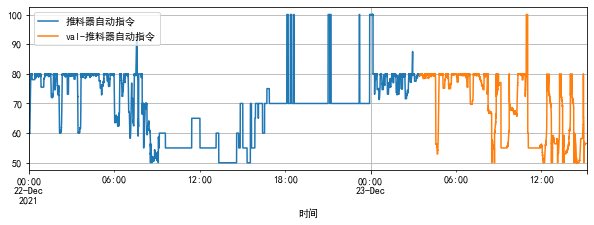

In [6]:
train_dataset, val_dataset = train_val_dataset.split(0.7)
train_dataset.plot(add_data=[val_dataset], labels=['val'])

In [7]:
scaler = StandardScaler()
scaler.fit(train_dataset)
train_dataset_scaled = scaler.transform(train_dataset)
val_dataset_scaled = scaler.transform(val_dataset)
test_dataset_scaled = scaler.transform(test_dataset)

In [8]:
# 查看PaddleTS库内置的评估指标
??paddlets.metrics

In [9]:
lstm = LSTNetRegressor(in_chunk_len=1800,
                       out_chunk_len=1800,
                       eval_metrics=['mse'],
                       batch_size=32,
                       max_epochs=20)

In [10]:
lstm.fit(train_dataset_scaled, val_dataset_scaled)


[2022-11-23 11:39:21,291] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 000| loss: 0.486363| val_0_mse: 0.808936| 0:05:09s
[2022-11-23 11:44:20,397] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 001| loss: 0.473276| val_0_mse: 0.698059| 0:10:08s
[2022-11-23 11:49:20,106] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 002| loss: 0.472275| val_0_mse: 0.762476| 0:15:08s
[2022-11-23 11:54:19,586] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 003| loss: 0.464351| val_0_mse: 0.773702| 0:20:08s
[2022-11-23 11:59:18,355] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 004| loss: 0.463435| val_0_mse: 0.755354| 0:25:06s
[2022-11-23 12:04:17,464] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 005| loss: 0.460101| val_0_mse: 0.775763| 0:30:05s
[2022-11-23 12:09:16,401] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 006| loss: 0.458275| val_0_mse: 0.737988| 0:35:04s
[2022-11-23 12:14:17,707] [paddlets.models.common.callb

In [11]:
# save the model for multiple times.
# lstm.save("model")
from paddlets.models.model_loader import load
# loaded_lstm = load("lstm")

[2022-11-23 13:04:13,129] [paddlets] [ERROR] ValueError: Failed to save model, target file already exists: E:\打工\竞赛\江苏大数据开发与应用大赛-智能制造赛道\复赛\model


ValueError: Failed to save model, target file already exists: E:\打工\竞赛\江苏大数据开发与应用大赛-智能制造赛道\复赛\model

In [12]:
# pred_test = lstm.predict(test_dataset_scaled)
# pred_test = lstm.recursive_predict(test_dataset_scaled, predict_length=1800)
# scaler.inverse_transform(val_dataset_scaled)['推料器自动指令']
# 利用训练集往后预测1800条
pred_test = lstm.recursive_predict(val_dataset_scaled, predict_length=1800)

[2022-11-23 14:10:42,558] [paddlets.models.utils] [WARNING] Input `CO含量` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-23 14:10:42,563] [paddlets.models.utils] [WARNING] Input `HCL含量` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-23 14:10:42,563] [paddlets.models.utils] [WARNING] Input `NOx含量` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-23 14:10:42,564] [paddlets.models.utils] [WARNING] Input `SO2含量` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-23 14:10:42,564] [paddlets.models.utils] [WARNING] Input `二次风调门` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-23 14:10:42,565] [paddlets.models.utils] [WARNING] Input `二次风量` contains np.inf or np.NaN, which may lead to unexpected results from the model.


In [13]:
pred_test = scaler.inverse_transform(pred_test)
pred_test

                       推料器自动指令
2021-12-23 15:13:08  53.718010
2021-12-23 15:13:09  54.384480
2021-12-23 15:13:10  54.497398
2021-12-23 15:13:11  54.268726
2021-12-23 15:13:12  54.112034
...                        ...
2021-12-23 15:43:03  61.322609
2021-12-23 15:43:04  61.055836
2021-12-23 15:43:05  60.830479
2021-12-23 15:43:06  61.615883
2021-12-23 15:43:07  60.910683

[1800 rows x 1 columns]

In [14]:
pred_test = pred_test.to_dataframe()
pred_test

,推料器自动指令
2021-12-23 15:13:08,53.718010
2021-12-23 15:13:09,54.384480
2021-12-23 15:13:10,54.497398
2021-12-23 15:13:11,54.268726
2021-12-23 15:13:12,54.112034
...,...
2021-12-23 15:43:03,61.322609
2021-12-23 15:43:04,61.055836
2021-12-23 15:43:05,60.830479
2021-12-23 15:43:06,61.615883


In [15]:
sub = pd.DataFrame()
sub['ID'] = list(range(1,1801))
sub['Time'] = test_df['时间']
sub['Aps'] = test_df['推料器启停'].astype(bool)
sub['Ai'] = pred_test['推料器自动指令'].values

sub.to_csv('./lstm.csv', index=False)

In [ ]:
# val_np = val_dataset_scaled.to_numpy()
# val_pd = pd.DataFrame(val_np)
# val_pd.columns = ['推料器自动指令','CO含量', 'HCL含量', 'NOx含量', 'SO2含量','二次风调门', '二次风量']
# val_pd['时间'] = train_df['时间'][-len(val_pd):].values
# val_pd.info()
#
# val_pd.head(5)

In [48]:
# test_np = test_dataset_scaled.to_numpy()
# test_pd = pd.DataFrame(test_np)
# test_pd.columns = ['CO含量', 'HCL含量', 'NOx含量', 'SO2含量','二次风调门', '二次风量']
# test_pd['时间'] = test_df['时间']
# test_pd.info()
#
# test_pd.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO含量    1800 non-null   float64
 1   HCL含量   1800 non-null   float64
 2   NOx含量   1800 non-null   float64
 3   SO2含量   1800 non-null   float64
 4   二次风调门   1800 non-null   float64
 5   二次风量    1800 non-null   float64
 6   时间      1800 non-null   object 
dtypes: float64(6), object(1)
memory usage: 98.6+ KB


,CO含量,HCL含量,NOx含量,SO2含量,二次风调门,二次风量,时间
0,0.418963,1.255305,-1.158377,-0.248295,-0.350331,-0.221616,2021-12-23 15:13:20
1,0.416627,1.263673,-1.158377,-0.249517,-0.349849,-0.249391,2021-12-23 15:13:21
2,0.417019,1.267827,-1.151519,-0.253188,-0.351909,-0.249391,2021-12-23 15:13:22
3,0.419349,1.246936,-1.143519,-0.250744,-0.350698,-0.288766,2021-12-23 15:13:23
4,0.429466,1.326374,-1.143519,-0.259308,-0.351547,-0.288766,2021-12-23 15:13:24


In [49]:
# val_test_pd = pd.concat([val_pd, test_pd])
# val_test_pd.info()
# val_test_pd.tail(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44157 entries, 0 to 1799
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   推料器自动指令  42357 non-null  float32
 1   CO含量     44157 non-null  float64
 2   HCL含量    44157 non-null  float64
 3   NOx含量    44157 non-null  float64
 4   SO2含量    44157 non-null  float64
 5   二次风调门    44157 non-null  float64
 6   二次风量     44157 non-null  float64
 7   时间       44157 non-null  object 
dtypes: float32(1), float64(6), object(1)
memory usage: 2.9+ MB


,推料器自动指令,CO含量,HCL含量,NOx含量,SO2含量,二次风调门,二次风量,时间
1795,NaN,-0.170016,0.052626,-0.321619,-0.322936,-0.327873,-0.221616,2021-12-23 15:43:15
1796,NaN,-0.172352,0.056810,-0.329619,-0.324569,-0.327873,-0.195115,2021-12-23 15:43:16
1797,NaN,-0.169630,0.060994,-0.319335,-0.325386,-0.328240,-0.221616,2021-12-23 15:43:17
1798,NaN,-0.175853,0.065178,-0.322761,-0.327835,-0.328963,-0.221616,2021-12-23 15:43:18
1799,NaN,-0.092603,0.154369,-0.283896,-0.343329,-0.329089,-0.195115,2021-12-23 15:43:19


In [50]:
# val_test_dataset = TSDataset.load_from_dataframe(
#     val_test_pd,
#     time_col='时间',
#     target_cols='推料器自动指令',
#     observed_cov_cols=['CO含量', 'HCL含量', 'NOx含量', 'SO2含量','二次风调门', '二次风量'],
#     freq='1s',
#     fill_missing_dates=True,
#     fillna_method='pre'
# )

In [156]:
# pred_test = lstm.recursive_predict(val_test_dataset, predict_length=44157)

[2022-11-22 15:03:47,069] [paddlets.models.utils] [WARNING] Input `CO含量` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-22 15:03:47,071] [paddlets.models.utils] [WARNING] Input `HCL含量` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-22 15:03:47,071] [paddlets.models.utils] [WARNING] Input `NOx含量` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-22 15:03:47,072] [paddlets.models.utils] [WARNING] Input `SO2含量` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-22 15:03:47,073] [paddlets.models.utils] [WARNING] Input `二次风调门` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-22 15:03:47,073] [paddlets.models.utils] [WARNING] Input `二次风量` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-22 15:03:47,157] [paddlets.models.utils] [WARNING] Input `CO含量` conta

In [148]:
# pred_test = scaler.inverse_transform(pred_test)

In [149]:
# pred_test = pred_test.to_numpy().reshape((-1,)).tolist()
# print(len(pred_test))

44157


In [150]:
# pred_test = pred_test[-1800:]

In [151]:
# print(len(pred_test))

1800


In [152]:
# pred_test

[75.19662475585938,
 75.356689453125,
 75.31344604492188,
 75.36109924316406,
 75.36593627929688,
 75.15899658203125,
 75.2154312133789,
 75.11009216308594,
 75.01980590820312,
 75.20703125,
 75.18190002441406,
 75.58802032470703,
 75.8727798461914,
 75.67240905761719,
 75.53047943115234,
 75.6817855834961,
 75.46343994140625,
 76.09027099609375,
 75.79389953613281,
 76.10359954833984,
 75.83394622802734,
 76.05439758300781,
 76.2610092163086,
 76.38572692871094,
 75.78016662597656,
 76.06388854980469,
 76.10713195800781,
 76.0942153930664,
 76.04679870605469,
 75.76520538330078,
 75.83578491210938,
 76.15200805664062,
 75.92876434326172,
 75.81303405761719,
 75.59272003173828,
 75.6584701538086,
 75.75543212890625,
 75.89460754394531,
 76.06883239746094,
 75.67975616455078,
 75.65542602539062,
 75.5116195678711,
 75.6042251586914,
 76.04434204101562,
 75.76444244384766,
 76.28569793701172,
 76.1117935180664,
 75.74425506591797,
 76.24858093261719,
 75.91956329345703,
 75.9973068237304

In [153]:
# val_dataset_scaled.plot(add_data=pred_test, labels=['pred'])
#

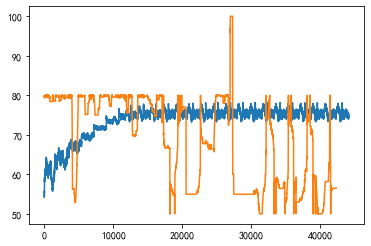

In [139]:
# plt.plot(range(len(pred_test['推料器自动指令'])), scaler.inverse_transform(pred_test)['推料器自动指令'])
# plt.plot(range(len(val_dataset_scaled['推料器自动指令'])),scaler.inverse_transform(val_dataset_scaled)['推料器自动指令'])

In [120]:
# val_dataset_scaled['推料器自动指令']
#

时间
2021-12-23 03:27:11    0.957563
2021-12-23 03:27:12    0.963121
2021-12-23 03:27:13    0.968679
2021-12-23 03:27:14    0.961671
2021-12-23 03:27:15    0.966830
                         ...   
2021-12-23 15:13:03   -1.203948
2021-12-23 15:13:04   -1.203948
2021-12-23 15:13:05   -1.203948
2021-12-23 15:13:06   -1.203948
2021-12-23 15:13:07   -1.203948
Freq: S, Name: 推料器自动指令, Length: 42357, dtype: float32

In [137]:
# scaler.inverse_transform(pred_test)
#

                       推料器自动指令
2021-12-23 15:43:20  54.850666
2021-12-23 15:43:21  54.229134
2021-12-23 15:43:22  54.191116
2021-12-23 15:43:23  54.197899
2021-12-23 15:43:24  54.416603
...                        ...
2021-12-24 03:59:12  74.886421
2021-12-24 03:59:13  74.645653
2021-12-24 03:59:14  74.835297
2021-12-24 03:59:15  75.349251
2021-12-24 03:59:16  75.083321

[44157 rows x 1 columns]

[2022-11-22 15:07:31,743] [paddlets.models.utils] [WARNING] Input `CO含量` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-22 15:07:31,744] [paddlets.models.utils] [WARNING] Input `HCL含量` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-22 15:07:31,744] [paddlets.models.utils] [WARNING] Input `NOx含量` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-22 15:07:31,745] [paddlets.models.utils] [WARNING] Input `SO2含量` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-22 15:07:31,745] [paddlets.models.utils] [WARNING] Input `二次风调门` contains np.inf or np.NaN, which may lead to unexpected results from the model.
[2022-11-22 15:07:31,745] [paddlets.models.utils] [WARNING] Input `二次风量` contains np.inf or np.NaN, which may lead to unexpected results from the model.


                      推料器自动指令      CO含量     HCL含量     NOx含量     SO2含量  \
时间                                                                      
2021-12-23 03:27:11  0.957563 -0.073148 -0.326444  0.017887 -0.250744   
2021-12-23 03:27:12  0.963121 -0.072369 -0.329213  0.009887 -0.253188   
2021-12-23 03:27:13  0.968679 -0.071204 -0.343150  0.006455 -0.247073   
2021-12-23 03:27:14  0.961671 -0.073540 -0.338966  0.014461 -0.247073   
2021-12-23 03:27:15  0.966830 -0.072369 -0.330598  0.006455 -0.249517   
...                       ...       ...       ...       ...       ...   
2021-12-23 15:13:03 -1.203948  0.420520  1.352834 -1.039495 -0.276030   
2021-12-23 15:13:04 -1.203948  0.404958  1.336127 -1.041785 -0.260941   
2021-12-23 15:13:05 -1.203948  0.404958  1.336127 -1.041785 -0.260941   
2021-12-23 15:13:06 -1.203948  0.409624  1.326374 -1.047501 -0.259713   
2021-12-23 15:13:07 -1.203948  0.408845  1.334743 -1.050927 -0.258086   

                        二次风调门      二次风量  
时间      